# Generative Adversarial Networks (GANs)

So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Example pictures of what you should expect (yours might look slightly different):

![caption](gan_outputs_tf.png)


## Setup

In [0]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session


## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the TensorFlow MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

**Heads-up**: The TensorFlow MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/da

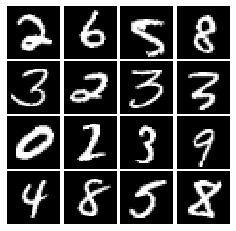

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## LeakyReLU
In the cell below, you should implement a LeakyReLU. See the [class notes](http://cs231n.github.io/neural-networks-1/) (where alpha is small number) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs keep ReLU units from dying and are often used in GAN methods (as are maxout units, however those increase model size and therefore are not used in this notebook).

HINT: You should be able to use `tf.maximum`

In [0]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    1
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    return tf.maximum(x, alpha * x)


## Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [0]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    return tf.random_uniform((batch_size, dim), minval= -1, maxval= 1)


## Discriminator
Our first step is to build a discriminator. You should use the layers in `tf.layers` to build the model.
All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from size 784 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 1
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [0]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        layer = tf.layers.Dense(256)(x)
        layer = tf.nn.leaky_relu(layer, alpha=0.01)
        layer = tf.layers.Dense(256)(layer)
        layer = tf.nn.leaky_relu(layer, alpha=0.01)
        layer = tf.layers.Dense(1)(layer)
        logits = layer
        return logits

## Generator
Now to build a generator. You should use the layers in `tf.layers` to construct the model. All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from tf.shape(z)[1] (the number of noise dimensions) to 1024
 * ReLU
 * Fully connected layer from 1024 to 1024 
 * ReLU
 * Fully connected layer from 1024 to 784
 * TanH (To restrict the output to be [-1,1])

In [0]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        layer = tf.layers.Dense(1024, activation='relu')(z)
        layer = tf.layers.Dense(1024, activation='relu')(layer)
        layer = tf.layers.Dense(784, activation='tanh')(layer)
        img = layer
        return img

# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: Use [tf.ones_like](https://www.tensorflow.org/api_docs/python/tf/ones_like) and [tf.zeros_like](https://www.tensorflow.org/api_docs/python/tf/zeros_like) to generate labels for your discriminator. Use [sigmoid_cross_entropy loss](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) to help compute your loss function. Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [0]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    #D_loss = tf.reduce_mean(-tf.log(tf.sigmoid(logits_real))) - tf.reduce_mean(tf.log(1-tf.sigmoid(logits_fake)))
    #G_loss = tf.reduce_mean(-tf.log(tf.sigmoid(logits_fake)))
    
    # you must use two losses summtion as it avraging over the batch size (dont use tf.concat)
    D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(logits_real)
                                                                   ,logits = logits_real)) + tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(logits_fake) ,logits = logits_fake))
    
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(logits_fake)
                                                                    ,logits = logits_fake ))
    return D_loss, G_loss

# Optimizing our loss
Make an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns to be too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [0]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    
    return D_solver, G_solver

## Putting it all together
Now just a bit of Lego Construction.. Read this section over carefully to understand how we'll be composing the generator and discriminator

In [10]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

Instructions for updating:
Colocations handled automatically by placer.


# Training a GAN!
Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000. In our case, we'll simply train D(x) and G(z) with one batch each every iteration. However, papers often experiment with different schedules of training D(x) and G(z), sometimes doing one for more steps than the other, or even training each one until the loss gets "good enough" and then switching to training the other. 

In [0]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

#### Train your GAN! This should take about 10 minutes on a CPU, or less than a minute on GPU.

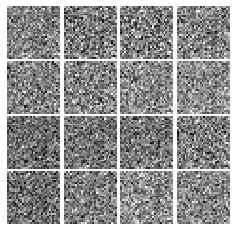


Iter: 0, D: 1.453, G:0.7328
Iter: 50, D: 0.3125, G:1.524
Iter: 100, D: 1.357, G:1.315
Iter: 150, D: 1.108, G:1.337
Iter: 200, D: 1.459, G:0.7788


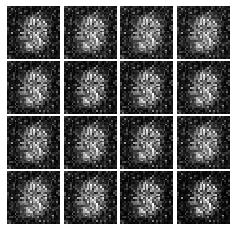


Iter: 250, D: 1.441, G:0.5521
Iter: 300, D: 1.042, G:1.289
Iter: 350, D: 1.235, G:1.333
Iter: 400, D: 1.307, G:1.061
Iter: 450, D: 1.312, G:0.928


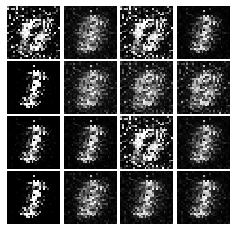


Iter: 500, D: 1.144, G:1.73
Iter: 550, D: 1.23, G:1.427
Iter: 600, D: 1.084, G:2.044
Iter: 650, D: 0.9249, G:1.845
Iter: 700, D: 0.7794, G:1.713


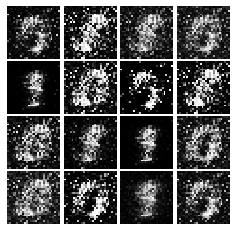


Iter: 750, D: 1.226, G:1.327
Iter: 800, D: 0.9613, G:1.592
Iter: 850, D: 1.178, G:1.261
Iter: 900, D: 1.427, G:0.3563
Iter: 950, D: 1.057, G:1.303


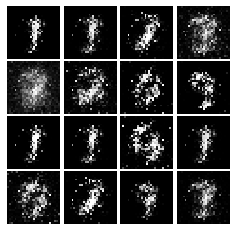


Iter: 1000, D: 1.157, G:1.576
Iter: 1050, D: 1.248, G:1.065
Iter: 1100, D: 1.177, G:0.9761
Iter: 1150, D: 1.073, G:1.03
Iter: 1200, D: 1.217, G:0.9942


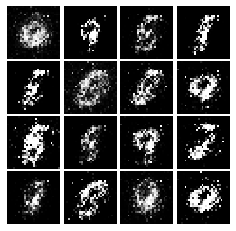


Iter: 1250, D: 1.143, G:1.17
Iter: 1300, D: 1.288, G:1.136
Iter: 1350, D: 1.21, G:1.705
Iter: 1400, D: 1.175, G:1.085
Iter: 1450, D: 1.21, G:0.9643


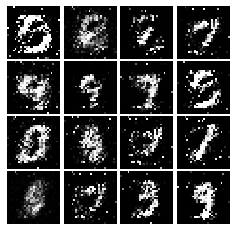


Iter: 1500, D: 1.283, G:0.929
Iter: 1550, D: 1.267, G:1.167
Iter: 1600, D: 1.217, G:1.036
Iter: 1650, D: 1.263, G:0.8154
Iter: 1700, D: 1.346, G:0.8399


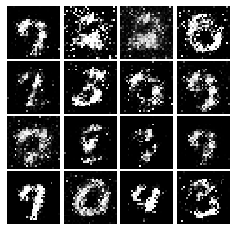


Iter: 1750, D: 1.32, G:0.944
Iter: 1800, D: 1.297, G:0.8566
Iter: 1850, D: 1.262, G:0.8643
Iter: 1900, D: 1.345, G:0.9232
Iter: 1950, D: 1.389, G:0.7615


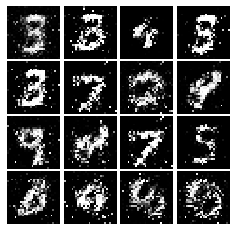


Iter: 2000, D: 1.342, G:0.7731
Iter: 2050, D: 1.376, G:0.8036
Iter: 2100, D: 1.243, G:0.8117
Iter: 2150, D: 1.318, G:0.7935
Iter: 2200, D: 1.298, G:0.8842


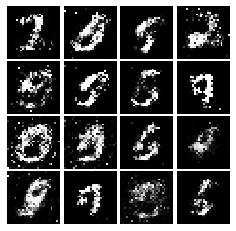


Iter: 2250, D: 1.288, G:0.8043
Iter: 2300, D: 1.253, G:0.8482
Iter: 2350, D: 1.373, G:0.8171
Iter: 2400, D: 1.351, G:0.7385
Iter: 2450, D: 1.323, G:0.9357


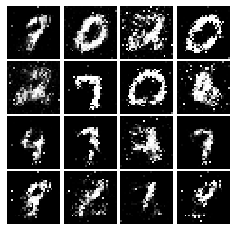


Iter: 2500, D: 1.333, G:0.7551
Iter: 2550, D: 1.383, G:0.8296
Iter: 2600, D: 1.353, G:0.7667
Iter: 2650, D: 1.344, G:0.8453
Iter: 2700, D: 1.295, G:0.8079


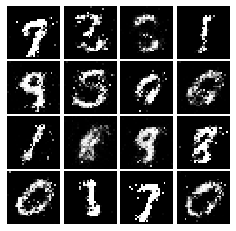


Iter: 2750, D: 1.393, G:0.8205
Iter: 2800, D: 1.386, G:0.6877
Iter: 2850, D: 1.362, G:0.8512
Iter: 2900, D: 1.26, G:0.7699
Iter: 2950, D: 1.336, G:0.8453


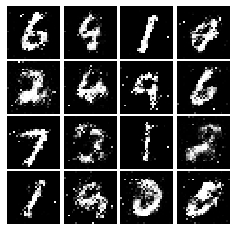


Iter: 3000, D: 1.268, G:0.984
Iter: 3050, D: 1.333, G:0.7569
Iter: 3100, D: 1.44, G:0.7755
Iter: 3150, D: 1.283, G:0.7943
Iter: 3200, D: 1.369, G:0.8524


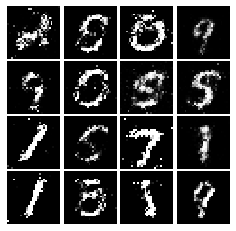


Iter: 3250, D: 1.301, G:0.739
Iter: 3300, D: 1.33, G:0.8432
Iter: 3350, D: 1.321, G:0.8111
Iter: 3400, D: 1.321, G:0.7071
Iter: 3450, D: 1.31, G:0.763


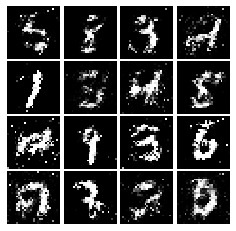


Iter: 3500, D: 1.344, G:0.7627
Iter: 3550, D: 1.266, G:0.8664
Iter: 3600, D: 1.224, G:0.8397
Iter: 3650, D: 1.356, G:0.8047
Iter: 3700, D: 1.339, G:0.7624


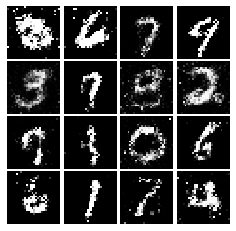


Iter: 3750, D: 1.33, G:0.7707
Iter: 3800, D: 1.322, G:0.7995
Iter: 3850, D: 1.311, G:0.8339
Iter: 3900, D: 1.328, G:0.844
Iter: 3950, D: 1.273, G:0.7926


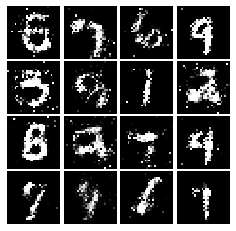


Iter: 4000, D: 1.301, G:0.8295
Iter: 4050, D: 1.319, G:0.8752
Iter: 4100, D: 1.312, G:0.9406
Iter: 4150, D: 1.287, G:0.8205
Iter: 4200, D: 1.373, G:0.7713


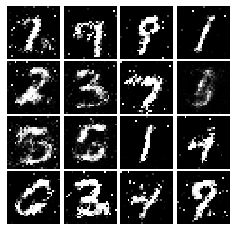


Iter: 4250, D: 1.285, G:0.8249
Final images


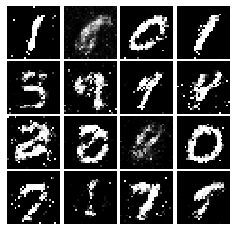

In [12]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`score_real` and `score_fake`).

In [0]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = .5 * tf.reduce_mean(tf.pow(score_real - 1, 2)) + .5 * tf.reduce_mean(tf.pow(score_fake, 2))
    G_loss = .5 * tf.reduce_mean(tf.pow(score_fake - 1, 2))
    pass
    return D_loss, G_loss

Test your LSGAN loss. You should see errors less than 1e-7.

Create new training steps so we instead minimize the LSGAN loss:

In [0]:
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

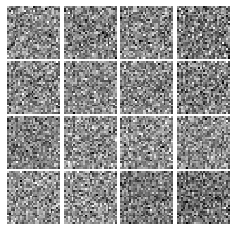


Iter: 0, D: 0.5484, G:0.4602
Iter: 50, D: 0.01131, G:0.6075
Iter: 100, D: 0.04292, G:0.6904
Iter: 150, D: 0.1461, G:0.6136
Iter: 200, D: 0.9046, G:0.3453


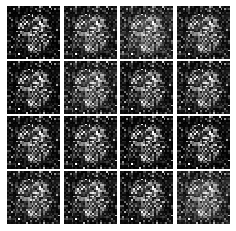


Iter: 250, D: 0.1296, G:0.4362
Iter: 300, D: 0.06711, G:0.6479
Iter: 350, D: 0.0741, G:0.4979
Iter: 400, D: 0.1172, G:0.535
Iter: 450, D: 0.1484, G:0.3935


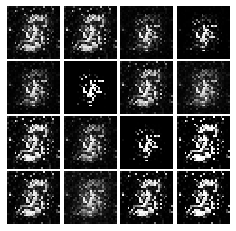


Iter: 500, D: 0.1235, G:0.354
Iter: 550, D: 0.3884, G:0.7825
Iter: 600, D: 0.1541, G:0.589
Iter: 650, D: 0.1207, G:0.5704
Iter: 700, D: 0.336, G:0.4874


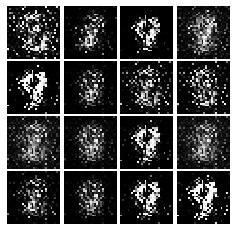


Iter: 750, D: 0.2287, G:0.5879
Iter: 800, D: 0.127, G:0.3222
Iter: 850, D: 0.1438, G:0.3608
Iter: 900, D: 0.118, G:0.3823
Iter: 950, D: 0.1286, G:0.3188


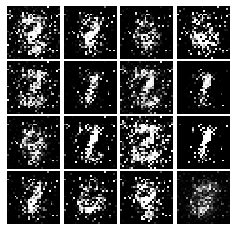


Iter: 1000, D: 0.1526, G:0.295
Iter: 1050, D: 0.1808, G:0.2797
Iter: 1100, D: 0.1828, G:0.4032
Iter: 1150, D: 0.1411, G:0.2935
Iter: 1200, D: 0.1737, G:0.2825


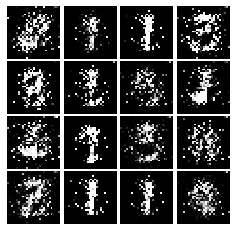


Iter: 1250, D: 0.1999, G:0.2308
Iter: 1300, D: 0.1799, G:0.2385
Iter: 1350, D: 0.1857, G:0.2534
Iter: 1400, D: 0.2597, G:0.07041
Iter: 1450, D: 0.1897, G:0.2297


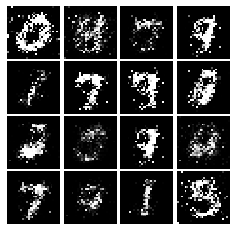


Iter: 1500, D: 0.1785, G:0.2564
Iter: 1550, D: 0.1803, G:0.2543
Iter: 1600, D: 0.2143, G:0.2306
Iter: 1650, D: 0.1654, G:0.2886
Iter: 1700, D: 0.1744, G:0.2467


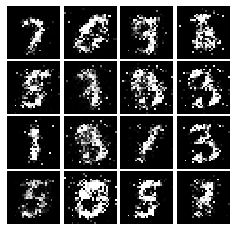


Iter: 1750, D: 0.1824, G:0.2191
Iter: 1800, D: 0.2068, G:0.2108
Iter: 1850, D: 0.2171, G:0.1931
Iter: 1900, D: 0.2296, G:0.1631
Iter: 1950, D: 0.2459, G:0.3568


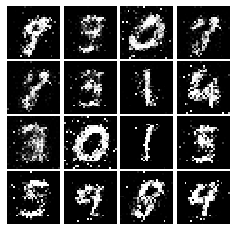


Iter: 2000, D: 0.2358, G:0.1691
Iter: 2050, D: 0.2435, G:0.2613
Iter: 2100, D: 0.2347, G:0.2314
Iter: 2150, D: 0.1962, G:0.1931
Iter: 2200, D: 0.2236, G:0.1763


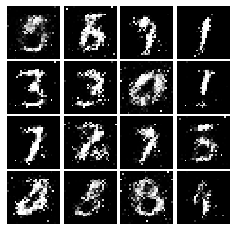


Iter: 2250, D: 0.2003, G:0.1713
Iter: 2300, D: 0.2241, G:0.2384
Iter: 2350, D: 0.2235, G:0.1721
Iter: 2400, D: 0.2036, G:0.1801
Iter: 2450, D: 0.2131, G:0.2166


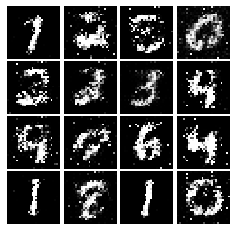


Iter: 2500, D: 0.2068, G:0.2115
Iter: 2550, D: 0.2231, G:0.1729
Iter: 2600, D: 0.2097, G:0.2061
Iter: 2650, D: 0.2165, G:0.2067
Iter: 2700, D: 0.2264, G:0.1915


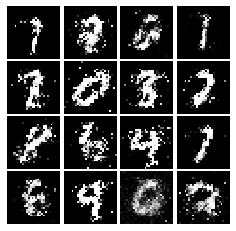


Iter: 2750, D: 0.1991, G:0.2046
Iter: 2800, D: 0.2368, G:0.1552
Iter: 2850, D: 0.2022, G:0.2055
Iter: 2900, D: 0.2183, G:0.2207
Iter: 2950, D: 0.2161, G:0.198


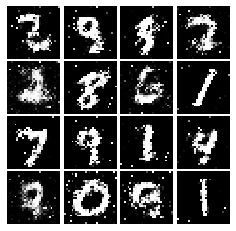


Iter: 3000, D: 0.2222, G:0.2117
Iter: 3050, D: 0.1983, G:0.1894
Iter: 3100, D: 0.2287, G:0.2049
Iter: 3150, D: 0.2055, G:0.2037
Iter: 3200, D: 0.2247, G:0.1672


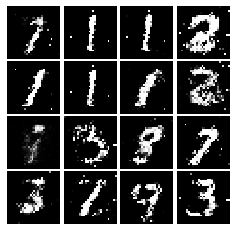


Iter: 3250, D: 0.2041, G:0.1753
Iter: 3300, D: 0.2381, G:0.1698
Iter: 3350, D: 0.2237, G:0.2221
Iter: 3400, D: 0.2001, G:0.1902
Iter: 3450, D: 0.2213, G:0.1717


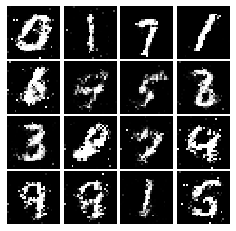


Iter: 3500, D: 0.2371, G:0.2007
Iter: 3550, D: 0.2186, G:0.17
Iter: 3600, D: 0.2143, G:0.208
Iter: 3650, D: 0.2283, G:0.1892
Iter: 3700, D: 0.2081, G:0.1682


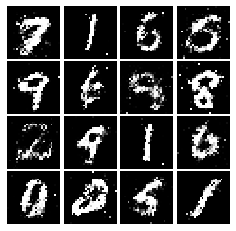


Iter: 3750, D: 0.2323, G:0.1766
Iter: 3800, D: 0.2276, G:0.1682
Iter: 3850, D: 0.2194, G:0.1727
Iter: 3900, D: 0.2303, G:0.1838
Iter: 3950, D: 0.219, G:0.1993


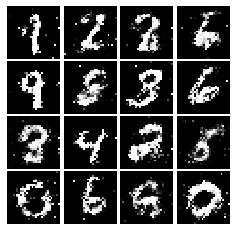


Iter: 4000, D: 0.2342, G:0.1823
Iter: 4050, D: 0.2252, G:0.1819
Iter: 4100, D: 0.2318, G:0.1924
Iter: 4150, D: 0.236, G:0.1754
Iter: 4200, D: 0.2285, G:0.1793


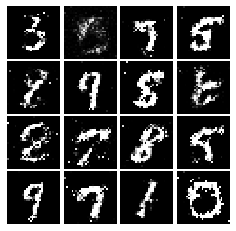


Iter: 4250, D: 0.2077, G:0.1849
Final images


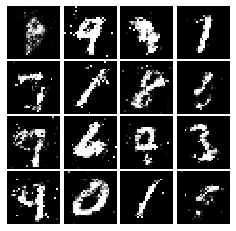

In [15]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)

# INLINE QUESTION 1:
Describe how the visual quality of the samples changes over the course of training. Do you notice anything about the distribution of the samples? How do the results change across different training runs?

** (Write Your Answer In This Cell) **
it's generate recognizable samples more faster, the distribtion of the samples are the same with diffrant noise inputs at the begning, but after some trianing the samples come more diverse 

# Deep Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks as our discriminators and generators.

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification [tutorial](https://www.tensorflow.org/get_started/mnist/pros), which is able to get above 99% accuracy on the MNIST dataset fairly quickly. *Be sure to check the dimensions of x and reshape when needed*, fully connected blocks expect [N,D] Tensors while conv2d blocks expect [N,H,W,C] Tensors. 

Architecture:
* 32 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* 64 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected size 4 x 4 x 64, Leaky ReLU(alpha=0.01)
* Fully Connected size 1

In [0]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        x = tf.reshape(x, [-1, 28, 28, 1])
        layer = tf.layers.conv2d(x, 32, kernel_size=(5,5))
        layer = tf.nn.leaky_relu(layer, alpha=.01)
        layer = tf.layers.max_pooling2d(layer, pool_size=(2,2), strides=(2,2))
        
        layer = tf.layers.conv2d(layer, 64, kernel_size=(5,5))
        layer = tf.nn.leaky_relu(layer, alpha=.01)
        layer = tf.layers.max_pooling2d(layer, pool_size=(2,2), strides=(2,2))
        
        layer = tf.layers.flatten(layer)
        layer = tf.layers.dense(layer, 1024)
        layer = tf.nn.leaky_relu(layer, alpha=.01)
        
        logits = tf.layers.dense(layer, 1)
        return logits

#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). We are always "training" in GAN mode.

Architecture:
* Fully connected of size 1024, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 128, ReLU
* BatchNorm
* Resize into Image Tensor
* 64 conv2d^T (transpose) filters of 4x4, stride 2, ReLU
* BatchNorm
* 1 conv2d^T (transpose) filter of 4x4, stride 2, TanH

In [0]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        
        # encoder
        layer = tf.layers.dense(z, 1024, activation='relu')
        layer = tf.layers.batch_normalization(layer)
        
        layer = tf.layers.dense(layer, 7*7*128, activation='relu')
        layer = tf.layers.batch_normalization(layer)
        
        layer = tf.reshape(layer, (layer.shape[0], 7, 7, 128))
        #decoder
        layer = tf.layers.conv2d_transpose(layer, filters=64, kernel_size=(4,4), padding='same' 
                                           , strides=2, activation='relu')
        layer = tf.layers.batch_normalization(layer)
        img = tf.layers.conv2d_transpose(layer, filters=1, kernel_size=(4,4), padding='same'
                                         , strides=2, activation='tanh')
    
        return img

We have to recreate our network since we've changed our functions.

In [20]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.flatten instead.


### Train and evaluate a DCGAN
This is the one part of A3 that significantly benefits from using a GPU. It takes 3 minutes on a GPU for the requested five epochs. Or about 50 minutes on a dual core laptop on CPU (feel free to use 3 epochs if you do it on CPU).

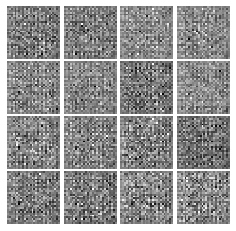


Iter: 0, D: 1.329, G:0.6562
Iter: 50, D: 0.7248, G:1.591
Iter: 100, D: 0.2088, G:3.136
Iter: 150, D: 0.9232, G:1.57
Iter: 200, D: 0.6329, G:3.323


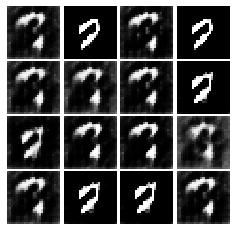


Iter: 250, D: 0.8063, G:0.9132
Iter: 300, D: 0.8052, G:1.42
Iter: 350, D: 0.1498, G:3.644
Iter: 400, D: 0.4495, G:3.076
Iter: 450, D: 1.153, G:5.09


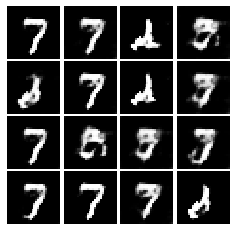


Iter: 500, D: 0.5731, G:2.422
Iter: 550, D: 0.4281, G:2.138
Iter: 600, D: 0.6032, G:2.371
Iter: 650, D: 0.4969, G:2.317
Iter: 700, D: 0.4696, G:3.33


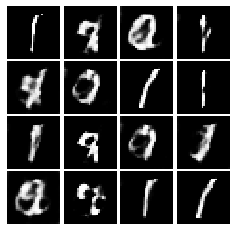


Iter: 750, D: 0.5866, G:1.883
Iter: 800, D: 0.5397, G:2.941
Iter: 850, D: 0.4155, G:2.546
Iter: 900, D: 0.3839, G:2.578
Iter: 950, D: 0.6479, G:2.063


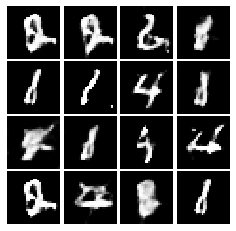


Iter: 1000, D: 0.4772, G:2.605
Iter: 1050, D: 0.5913, G:2.372
Iter: 1100, D: 0.3791, G:2.396
Iter: 1150, D: 0.4061, G:2.498
Iter: 1200, D: 0.5721, G:2.369


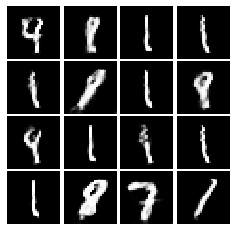


Iter: 1250, D: 0.46, G:2.17
Iter: 1300, D: 0.5265, G:2.345
Iter: 1350, D: 0.7772, G:2.797
Iter: 1400, D: 0.4624, G:2.576
Iter: 1450, D: 0.5398, G:2.224


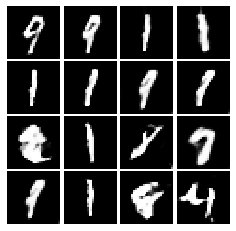


Iter: 1500, D: 0.7436, G:2.69
Iter: 1550, D: 0.5577, G:2.147
Iter: 1600, D: 0.6315, G:2.281
Iter: 1650, D: 0.6485, G:1.635
Iter: 1700, D: 0.563, G:1.635


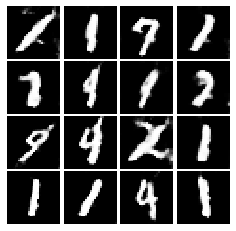


Iter: 1750, D: 0.6207, G:2.473
Iter: 1800, D: 0.5017, G:1.955
Iter: 1850, D: 0.4325, G:2.42
Iter: 1900, D: 0.4603, G:1.981
Iter: 1950, D: 0.6189, G:2.764


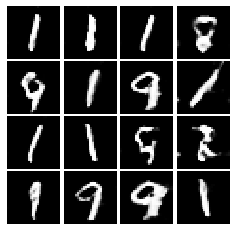


Iter: 2000, D: 0.6627, G:1.944
Iter: 2050, D: 0.6835, G:2.387
Iter: 2100, D: 0.6052, G:2.059
Final images


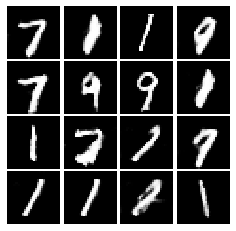

In [21]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=5)

# INLINE QUESTION 2:
What differences do you see between the DCGAN results and the original GAN results?

** (Write Your Answer In This Cell) **

It's produce images with a lot less noise and maintain the spatial shape much better, but it take a lot more time